In [7]:
%store -r Data_Set_N

import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv

import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable
from ipykernel import kernelapp as app
import scipy.stats as stats
import pylab as pl
from scipy.stats import norm
import statistics
import numpy.linalg as LA

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter
from Proof_of_Concept_KG import build_borrower_sector_graph,Loss_Function,my_agg_func

In [2]:
n = 0
for i in Data_Set_N.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break
        
print(len(Data_Set_N))

('9b1eabd9-e4e6-536f-b170-eb5fac7a78a0', {'Sector': '"33361"', 'Revenue': [0.1, 0.1, 0.1, 0.1, 0.1], 'EBITDA': [0, 0, 0, 0, 0], 'NDE': [1.0, 1.0, 1.0, 0, 0], 'TDE': [0, 0.39, 0.5, 0.67, 0]}) 

('f81f33f3-33e0-5ae0-b38d-45b320123515', {'Sector': '"311612"', 'Revenue': [0.1, 0.1, 0.1, 0.1, 0.1], 'EBITDA': [0, 0, 0, 0, 0], 'NDE': [0, 0, 0, 0, 0], 'TDE': [0, 0, 0, 0, 0]}) 

('9aed89eb-57c5-5d27-898d-2ecceda9b165', {'Sector': '"5241"', 'Revenue': [0.9, 0.9, 0.9, 0.9, 0.9], 'EBITDA': [0.7, 0.7, 0.7, 0.7, 0.7], 'NDE': [1.0, 0, 0.3, 0, 0], 'TDE': [0.66, 0.66, 0.61, 0.6, 0.63]}) 

7440


In [3]:
S = {}
for i in Data_Set_N.values():
    if i['Sector'][1:-1] in S.keys():
        S[i['Sector'][1:-1]] += 1
    else:
        S[i['Sector'][1:-1]] = 1

    
l = []
for i in S.items():
    sec,n = i
    if n > 30:
        l.append(sec)
        
print(l)
print(len(l))

sector_name = input()

if S[str(sector_name)] > 30:
    pass
else:
    print("Not enough entities, select other sector")


New_Data_Set = {}
for i in Data_Set_N.items():
    ID,data = i
    
    if data['Sector'][1:-1] == sector_name:
        New_Data_Set[ID] = data
        
    
n = 0
for i in New_Data_Set.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break
        
print(len(New_Data_Set))

['511210', '325414', '339112', '324110', '213112', '2111', '54151', '722511', '524126', '517312', '325412', '518210', '334413', '519130', '221210', '325', '722513', '517911', '541512', '334118', '2211', '515210', '524113', '517311', '541810', '334220', '721110', '3363', '334519', '334419', '531110', '486210', '22111', '221122', '334290', '33911', '334510', '339113', '512110', '515120']
40
2111
('2918d60e-55d2-514f-8263-060119f0e052', {'Sector': '"2111"', 'Revenue': [0.3, 0.3, 0.3, 0.3, 0.3], 'EBITDA': [0.3, 0.3, 0.3, 0.2, 0.3], 'NDE': [0, 0, 0, 0, 0], 'TDE': [0, 0, 0, 0, 0]}) 

('f6c7cd56-c439-5d40-8d65-9839caa40b2b', {'Sector': '"2111"', 'Revenue': [0.6, 0.6, 0.6, 0.6, 0.6], 'EBITDA': [0.5, 0.5, 0.5, 0.5, 0.5], 'NDE': [0.0, 0, 0, 0, 0.0], 'TDE': [0.2, 0, 0, 0, 0.26]}) 

('f80c7cf4-bf79-5124-a7f4-722eba9aea84', {'Sector': '"2111"', 'Revenue': [0.1, 0.1, 0.1, 0.1, 0.1], 'EBITDA': [0, 0, 0, 0.1, 0], 'NDE': [0, 0, 1.0, 0, 0.9], 'TDE': [0, 0.15, 0.71, 0.93, 0.93]}) 

236


In [6]:
G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(New_Data_Set)
print("No.of Borrowers ", n_borrowers, " No.of Sectors ", n_sectors)

{'"2111"'}
No.of Borrowers  236  No.of Sectors  1


In [8]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv2 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_RE, out_RE, 'none',False, activation = None, bias = False) for rel in L2_names}, aggregate='mean')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_NT, out_NT, 'none',False, activation = None, bias = False) for rel in L3_names}, aggregate='mean')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower,'none', activation = None,bias = False) for rel in L5_names},aggregate = 'sum')

    def forward(self, graph, inputs):
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        #h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        #print("R", inputs['R'], "E", inputs['E'],"R&E ", h_RE['R&E'].dtype)
        
        NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
        h_NT = self.conv3(graph, NT_inputs)
        #h_NT = {k: F.relu(v) for k, v in h_NT.items()}
        #print("NDE", inputs['NDE'], "TDE", inputs['TDE'],"NDE&TDE ", h_NT['NDE&TDE'])
        
        
        E = my_agg_func([h_RE['R&E'],h_NT['NDE&TDE']],15,'borrower')
        #E = my_conc_func(h_RE['R&E'],h_NT['NDE&TDE'])
        
        borrower_inputs = {'borrower' : inputs['dummy_borrower'], 'R&E' : E}#,'sector' : h_sector['sector'], 'Description' : h_Des['Description']}
        
        h_borrower = self.conv5(graph, borrower_inputs)
        #h_borrower = {k: T.relu(v) for k, v in h_borrower.items()}
        #print("Borrower Embeddings ", h_borrower)
        
        return h_borrower
    

In [9]:
model = RGCN(5,5,5,5,768,768,768,768,15,15, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])

for i in New_Data_Set.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    E_Att = T.tensor([data['EBITDA']])
    NDE_Att = T.tensor([data['NDE']])
    TDE_Att = T.tensor([data['TDE']])
    break
    
for i in New_Data_Set.items():
    ID,data = i
    R_Att = T.cat((R_Att,T.tensor([data['Revenue']])),0)
    E_Att = T.cat((E_Att,T.tensor([data['EBITDA']])),0)
    NDE_Att = T.cat((NDE_Att,T.tensor([data['NDE']])),0)
    TDE_Att = T.cat((TDE_Att,T.tensor([data['TDE']])),0)
    
    
    
G.nodes['borrower'].data['f'] = T.ones(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.ones(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.ones(n_borrowers,5)
# G.nodes['Att_Description'].data['f'] = T.ones(n_borrowers,768)
# G.nodes['Description'].data['f'] = T.ones(n_borrowers,768)
# G.nodes['Factor'].data['f'] = T.ones(n_sectors,768)
# G.nodes['sector'].data['f'] = T.ones(n_sectors,768)

In [10]:
borrower_feats = G.nodes['borrower'].data['f']
# sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
# Des_feats = G.nodes['Description'].data['f']
# Des_att_feats = G.nodes['Att_Description'].data['f']
# factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.ones(n_borrowers,15)

node_features = {'borrower':borrower_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,
                 'TDE':TDE_feats,'NDE&TDE': NT_feats,
                 'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 4
Loss = []
epochs = 101

    
for epoch in range(epochs):
        
    model.train()                              # Forward Propogation
    logits = model(G, node_features)
    Borrower_Emb = logits['borrower'].detach().numpy()

    
    if epoch%25 == 0: 
        
        training_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(Borrower_Emb)    # K_Means Clustering
        centers = training_kmeans.cluster_centers_
        
        #TSNE before training
#         if epoch == 0:
#             fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
#             fashion_scatter(fashion_tsne, training_kmeans.labels_)
        
        
        target_centers = []
        for i in Borrower_Emb:
            l = []
            for j in centers:
                mse = np.square(i - j).mean()
                l.append(mse)

            target_centers.append(l.index(min(l)))


        centers = T.tensor(centers)
        target_centers = centers[T.tensor(target_centers)]
    

    loss = Loss_Function(logits['borrower'], target_centers, centers, training_kmeans.labels_)     # Loss Calculation
    Loss.append(loss.tolist())

    
    opt.zero_grad()             # Back Propogation
    loss.backward()
    opt.step()
    


# training_labels = training_kmeans.labels_
# %store training_labels

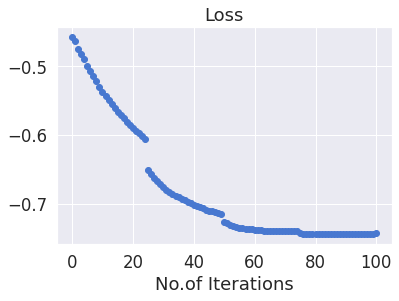

In [11]:
plt.scatter(list(range(len(Loss))),Loss)
plt.title("Loss")
plt.xlabel("No.of Iterations")
plt.show()

# fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
# fashion_scatter(fashion_tsne, training_kmeans.labels_)

In [12]:
n = 0
for i in Borrower_Emb:
    print(i,"\n")
    n += 1
    if n == 3:
        break

[ 0.0878858   0.04239262 -0.04877112 -0.01713539  0.09781418 -0.01226786
 -0.06968946 -0.08390062  0.00109323 -0.00900131  0.08725873 -0.02250268
  0.09260736  0.09409042 -0.04146211] 

[ 0.18073304  0.08715848 -0.10024682 -0.03522829  0.2011304  -0.02522811
 -0.14331284 -0.17249492  0.00223909 -0.01851276  0.17943877 -0.04625347
  0.19043376  0.19346899 -0.08522482] 

[ 0.07948542  0.03853095 -0.04437843 -0.01555079  0.08805142 -0.01112707
 -0.06353818 -0.07616884  0.00143769 -0.00819798  0.0789794  -0.0203124
  0.08373723  0.08510765 -0.03756404] 



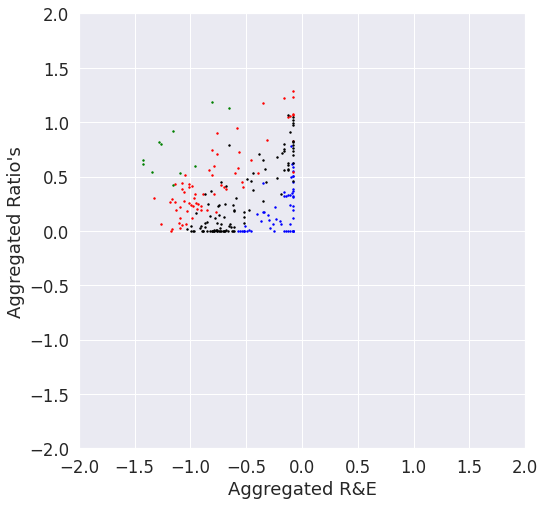

In [13]:
d = 1

Rev = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 0)[0]]
Net = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 0)[0]]


Rev2 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 1)[0]]
Net2 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 1)[0]]


Rev3 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 2)[0]]
Net3 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 2)[0]]


Rev4 = my_agg_func([R_Att[1:],E_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 3)[0]]
Net4 = my_agg_func([NDE_Att[1:],TDE_Att[1:]],d,'borrower')[np.where(training_kmeans.labels_ == 3)[0]]

plt.figure(figsize = (8,8))
plt.scatter(-Rev,Net,s = 2,c = np.array(['blue']))
plt.scatter(-Rev2,Net2, s= 2, c = np.array(['red']))
plt.scatter(-Rev3,Net3, s = 2, c = np.array(['green']))
plt.scatter(-Rev4,Net4, s = 2, c= np.array(['black']))
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.ylabel("Aggregated Ratio's")
plt.xlabel("Aggregated R&E")
plt.show()

In [14]:
M = []
for h in range(10,50):
    if h < n_borrowers:
        H = []
        KNN = NearestNeighbors(n_neighbors=h).fit(Borrower_Emb)

        for p in range(n_borrowers):
            distances, indices = KNN.kneighbors([Borrower_Emb[p]])

            indices[0].sort()
            #print("Borrower ",p," neighbors ",indices[0])

            n = 0
            l = []
            for i in New_Data_Set.items():
                ID,data = i

                if n in indices[0]:
                    for j in range(3):
                        if n in np.where(training_kmeans.labels_ == j)[0]:
                            l.append(j)                   
                n += 1

            if all(element == l[0] for element in l):
                pass
            else:
                H.append(p)
            
        M.append(len(H)*100/n_borrowers)
    
    else:
        break

NameError: name 'NearestNeighbors' is not defined

In [ ]:
plt.plot(np.arange(10,len(M)+10),M)
plt.xlabel("No.of Neighbors")
plt.ylabel("% Borrowers in mixed clusters ")
plt.show()

[0, 2, 6, 14, 15, 22, 32, 44, 47, 51, 54, 61, 63, 64, 65, 73, 78, 88, 90, 91, 92, 95, 99, 104, 106, 107, 114, 116, 118, 119, 121, 123, 129, 131, 134, 142, 151, 153, 165, 167, 168, 174, 178, 179, 182, 187, 194, 195, 196, 197, 205, 209, 210, 219, 226, 227, 232] [1, 4, 5, 8, 9, 11, 12, 16, 17, 20, 21, 25, 26, 27, 28, 29, 30, 31, 33, 34, 37, 40, 41, 43, 45, 46, 49, 50, 52, 53, 56, 57, 59, 60, 62, 66, 70, 71, 74, 77, 79, 82, 83, 84, 86, 89, 96, 97, 98, 100, 101, 102, 103, 108, 109, 110, 113, 115, 117, 120, 122, 124, 126, 128, 132, 135, 136, 138, 139, 140, 141, 145, 146, 147, 148, 149, 150, 154, 155, 157, 158, 159, 164, 166, 170, 171, 172, 173, 177, 180, 183, 184, 186, 188, 193, 198, 199, 200, 201, 203, 206, 213, 214, 217, 218, 220, 223, 224, 228, 229, 231, 234, 235] [3, 7, 10, 13, 18, 19, 23, 24, 35, 36, 38, 39, 42, 48, 55, 58, 67, 68, 69, 72, 75, 76, 80, 81, 85, 87, 93, 94, 105, 111, 112, 125, 127, 130, 133, 137, 143, 144, 152, 156, 160, 161, 162, 163, 169, 175, 176, 181, 185, 189, 190, 19

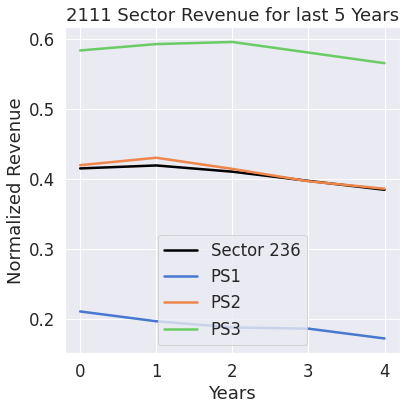

In [15]:
X_1 = logits['borrower'].detach().numpy()
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(X_1)

PS1_1 = []
PS2_1 = []
PS3_1 = []

for i in range(len(kmeans_1.labels_)):
    if kmeans_1.labels_[i] == 0:
        PS1_1.append(i)
    elif kmeans_1.labels_[i] == 1:
        PS2_1.append(i)
    elif kmeans_1.labels_[i] == 2:
        PS3_1.append(i)
    
print(PS1_1,PS2_1,PS3_1)
        
Psector1_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_1 = np.array([0.,0.,0.,0.,0.])
sector_rev = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in New_Data_Set.items():
    ID,data = i
    if n in PS1_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_1 += np.array(data['Revenue'])
        m += 1
    if n in PS2_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector2_rev_1 += np.array(data['Revenue'])
        p += 1
    if n in PS3_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector3_rev_1 += np.array(data['Revenue'])
        q += 1
    
    sector_rev += np.array(data['Revenue'])
           
    n += 1
    
Psector1_rev_1 = Psector1_rev_1/m
Psector2_rev_1 = Psector2_rev_1/p
Psector3_rev_1 = Psector3_rev_1/q
print(m,p,q)
sector_rev = sector_rev/n

plt.figure(figsize = (6,6))
S, = plt.plot(range(len(sector_rev)),sector_rev,'k')
ps1, = plt.plot(range(len(Psector1_rev_1)),Psector1_rev_1)
ps2, = plt.plot(range(len(Psector2_rev_1)),Psector2_rev_1)
ps3, = plt.plot(range(len(Psector3_rev_1)),Psector3_rev_1)
plt.legend([S,ps1,ps2,ps3],[ 'Sector '+str(n_borrowers), 'PS1', 'PS2', 'PS3'])
plt.title(sector_name + " Sector Revenue for last 5 Years")
plt.xlabel("Years")
plt.ylabel("Normalized Revenue")
plt.show()